In [57]:
import pandas
df = pandas.read_csv("loan_data_cleaned.csv", sep='\t', encoding='utf-8', )

<h2>Construct train and test set </h2>

In [58]:
for k in df.keys():
    if df[k].max() > 1.5:
        df[k] = (df[k] - df[k].mean())/df[k].std()

In [59]:
from sklearn.cross_validation import train_test_split
df['not_default'] = 1 - df['default']
Xs = df.drop(columns=['default', 'not_default']).values
Ys = df[['default', 'not_default']].values
# Xs = (Xs - Xs.mean())/Xs.std(axis=0)  # Normalize
X_train, X_test, Y_train, Y_test = train_test_split(Xs, Ys, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(170016, 44)
(72865, 44)
(170016, 2)
(72865, 2)


<h2>TensorFlow</h2>

In [60]:
import tensorflow as tf
tf.reset_default_graph()

In [61]:
x = tf.placeholder(tf.float64, shape=[None, 44])
y = tf.placeholder(tf.int64, shape=[None, 2])

with tf.name_scope('weights'):
    W1 = tf.Variable(tf.truncated_normal([44,2],stddev=0.01, dtype=tf.float64))
    tf.summary.histogram('histogram', W1)
with tf.name_scope('biases'):
    b1 = tf.Variable(tf.truncated_normal([2],stddev=0.01, dtype=tf.float64))
    tf.summary.histogram('histogram', b1)

In [62]:
pred = tf.matmul(x, W1) + b1

In [63]:
with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [64]:
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

In [65]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(pred, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [66]:
merged = tf.summary.merge_all()

In [67]:
# with tf.Session() as sess:
sess = tf.Session()
train_writer = tf.summary.FileWriter('./sess1/', sess.graph)
sess.run(tf.global_variables_initializer())
import numpy as np
import tqdm
import random
for i in tqdm.tqdm(range(100000)):
    idx = np.random.choice(np.arange(len(X_train)), 1000)
    batch_Xs = X_train[idx]
    batch_Ys = Y_train[idx]
    summary, _ = sess.run([merged, train_step], feed_dict={x: batch_Xs, y: batch_Ys})
#     sess.run(accuracy, feed_dict= {x:X_test, y:Y_test})
#     summary = sess.run(merged, feed_dict= {x:X_test, y:Y_test})
    train_writer.add_summary(summary, i)

100%|██████████| 100000/100000 [02:37<00:00, 636.40it/s]


In [68]:
p =sess.run(tf.nn.softmax(pred), feed_dict={x: X_test})

In [69]:
w1 = sess.run(W1, feed_dict={x: X_train})

In [70]:
X_test[0].dot(w1)

array([ 0.36575089, -0.2038553 ])

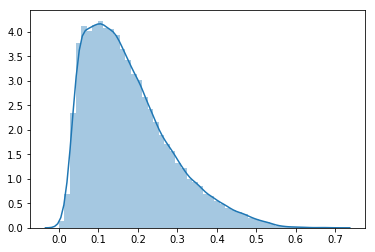

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.distplot(p[:,0])

In [72]:
sess.run(b1, feed_dict={x: X_train})

array([-0.46233633,  0.46366171])